# Using CNN to study the Ising model phase transitions

This notebook is based on the paper **[Machine learning phases of matter][ml]**. However, most of the visualizations found in the end was based on **[Grad-CAM][viz2]** and **[?]**


[ml]:http://dx.doi.org/10.1038/nphys4035
[viz2]:https://doi.org/10.1109/ICCV.2017.74

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle,os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint 
import sys, os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


#### Parameters plot 

In [2]:
#plt.rcParams['figure.figsize'] = [6.32, 5.11]
#plt.rcParams['figure.constrained_layout.use'] = True

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelpad'] = 15

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 3

plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.major.width'] = 3

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.markerscale'] = 1

plt.rcParams['lines.markersize'] = 9
plt.rcParams['lines.linewidth'] = 2

In [3]:
path = '../Data/'
dataset_name = 'Ising2DFM_reSample_L40_T=All.pkl'
dataset_label_name = 'Ising2DFM_reSample_L40_T=All_labels.pkl'

In [4]:
# Lattice size.
L = 40

# Temperatures values.
temp_val = np.arange(0.25, 4.0001, 0.25)

# Number of samples simulated in each temperature.
temp_samples = 10000

# Total number o samples.
total_samples = temp_samples * temp_val.shape[0]

# Dataset test size.
test_size = 0.1

# Dataset validattion size.
val_size = 0.2

In [5]:
# Loading the dataset.
data = pickle.load(open(path + dataset_name,'rb'))
data = np.unpackbits(data).reshape(-1, L * L).astype(float)

# This dataset has values 0 or 1, but Ising model has values -1 and 1.
data[np.where(data==0)]=-1

# Loading the dataset labels.
#labels = pickle.load(open(path + dataset_label_name,'rb'))

In [6]:
# Build temperatures labels for every sample.
temp_labels = np.hstack([np.repeat(temp, temp_samples) for temp in temp_val])

In [7]:
from keras.utils import to_categorical
labels = to_categorical(temp_labels, temp_val.shape[0])

In [8]:
X = data
Y = np.column_stack((labels, temp_labels))
    
del data, labels

In [9]:
# Split train, test and validation.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size)

del X, Y

In [11]:
# Reshape all array (L*L) in images (L,L).

X_train = np.reshape(X_train, (X_train.shape[0], L, L, 1))
X_test = np.reshape(X_test, (X_test.shape[0], L, L, 1))
X_val = np.reshape(X_val, (X_val.shape[0], L, L, 1))

In [12]:
# Creat the model.

model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='tanh', input_shape=(L, L, 1)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(720, activation='relu'))

#model.add(Dropout(0.5))
          
model.add(Dense(temp_val.shape[0], activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 36, 36, 128)       3328      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 720)               2949840   
_________________________________________________________________
dense_2 (Dense)              (None, 16)               

In [14]:
# Train the model.
history = model.fit(X_train, Y_train[:, 0:-1], validation_data=(X_val, Y_val[:, 0:-1]), batch_size=128, epochs=37)


Epoch 1/37
144000/144000 [==============================] - 37s 254us/step - loss: 0.3940 - accuracy: 0.8242
Epoch 2/37
144000/144000 [==============================] - 35s 246us/step - loss: 0.3195 - accuracy: 0.8648
Epoch 3/37
144000/144000 [==============================] - 35s 243us/step - loss: 0.2925 - accuracy: 0.8772
Epoch 4/37
144000/144000 [==============================] - 35s 243us/step - loss: 0.2799 - accuracy: 0.8853
Epoch 5/37
144000/144000 [==============================] - 35s 243us/step - loss: 0.2686 - accuracy: 0.8894
Epoch 6/37
144000/144000 [==============================] - 35s 244us/step - loss: 0.2692 - accuracy: 0.8899
Epoch 7/37
144000/144000 [==============================] - 35s 243us/step - loss: 0.2548 - accuracy: 0.8961
Epoch 8/37
144000/144000 [==============================] - 35s 245us/step - loss: 0.2523 - accuracy: 0.8985
Epoch 9/37
144000/144000 [==============================] - 35s 245us/step - loss: 0.2441 - accuracy: 0.9020
Epoch 10/37
144000

In [15]:
# Calculate test scores.
score = model.evaluate(X_test, Y_test[:, 0:-1], verbose=0)
print('Test accuracy: {1:6.4f} \nTest loss: {0:6.4f}'.format(score[0], score[1]))

Test accuracy: 0.8769 
Test loss: 0.7577


KeyError: 'val_loss'

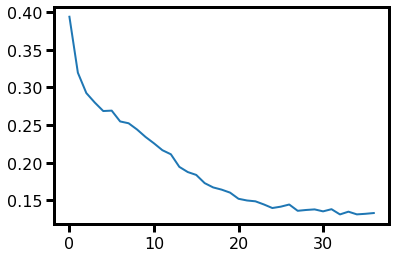

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

KeyError: 'val_accuracy'

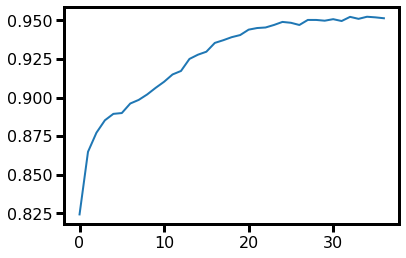

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [18]:
# Get datast test predictions.
res_test = model.predict(X_test)

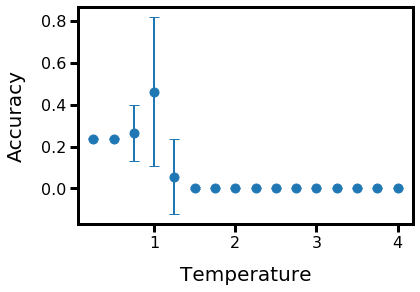

In [19]:
# Accuracy plot for every temperature.

acc = np.zeros(temp_val.shape[0])
acc_std = np.zeros(temp_val.shape[0])

for idx, temp in enumerate(temp_val):
    
    
    pos = np.argwhere(Y_test[:, -1] == temp)[:, 0]
    
    aux = res_test[pos, 0] - Y_test[pos, 0]
    acc[idx] = np.mean(np.abs(aux))
    acc_std[idx] = np.std(np.abs(aux))

    
    
plt.errorbar(x=temp_val, y=acc,
             yerr=acc_std, fmt='o', capsize=5)

plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.show()

### adicionar comentários.

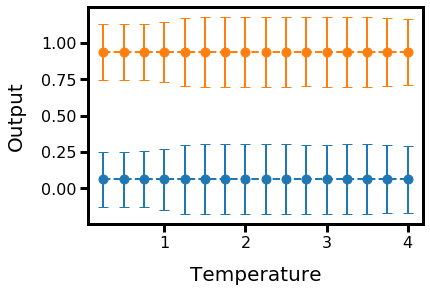

In [20]:
# Output value plot for every temperature.

#%matplotlib notebook
output_mean = np.zeros(temp_val.shape[0])
output_std = np.zeros(temp_val.shape[0])

for idx, temp in enumerate(temp_val):
    
       
    pos = np.argwhere(Y_test[:, -1] == temp)[:, 0]
    
    output_mean[idx] = np.mean(res_test[pos])
    output_std[idx] = np.std(res_test[pos])
    
plt.errorbar(x=temp_val, y=output_mean, yerr=output_std,
             fmt='o', capsize=5, linestyle='--')

plt.errorbar(x=temp_val, y=np.abs(output_mean - 1),
             yerr=output_std, fmt='o', capsize=5, linestyle='--')

plt.ylabel('Output')
plt.xlabel('Temperature')
plt.show()

### adicionar comentários.

## CNN's kernels

In [31]:
# Get filters values
filters, biases = model.layers[0].get_weights()
filters_number = filters.shape[-1]

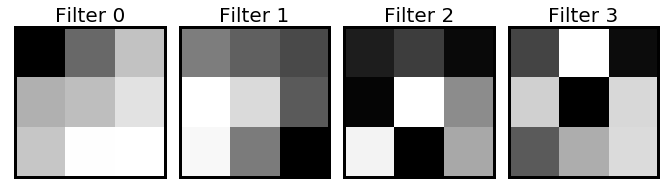

In [36]:
# Filters plot.
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(filters_number, figsize=[20,6])

for idx in range(filters_number):
    
    f = filters[:, :, 0, idx]
    
    grid = np.ceil(filters_number / 6.).astype(np.int32)
    
    axis = plt.subplot(grid, 6, idx+1)
    axis.set_xticks([])
    axis.set_yticks([])
    mp = axis.imshow(f, cmap='Greys')
    plt.title('Filter ' + str(idx))
    #fig.colorbar(mp, ax=axis)
    
plt.subplots_adjust(right=0.8, hspace=0.1, wspace=0.1)
plt.show()

In [32]:
from keras.models import Model

# Get the first conv layer
layer = model.layers[0]

# Create a new model that receives a input with shape (40,40,1) and output
# conv layer results.
model_output = Model(inputs=model.inputs, outputs=layer.output)

In [33]:
# Get predictions using the new model.
predict = model_output.predict(X_test)

In [34]:
# Indexs for critical, ordered and disordered regions.
critical_id = np.where(Y_test==2.25)[0]
ordered_id = np.where(Y_test==1.)[0]
disordered_id = np.where(Y_test==4.)[0]

In [35]:
def kernels_plot(filters_number, pred):
    
    fig, ax = plt.subplots(filters_number, figsize=[20, 12])

    for f_idx in range(filters_number):
    
        f = pred[:, :, f_idx]
        
        grid = np.ceil(filters_number / 6.).astype(np.int32)

        axis = plt.subplot(grid, 6, f_idx+1)
        axis.set_xticks([])
        axis.set_yticks([])
        mp = axis.imshow(f, origin='lower', cmap='bone') #bone, copper, hot, afmhot
        plt.title('Filter ' + str(f_idx))
        #fig.colorbar(mp, ax=axis)
    
    fig.subplots_adjust(right=0.8, hspace=-0.5, wspace=0.1)
    plt.show()

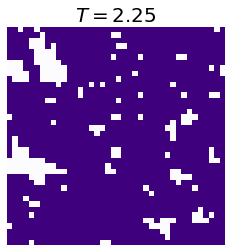

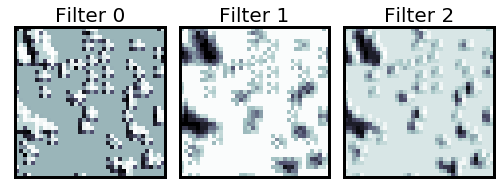

In [36]:
# Filters activations for a sample at critical region.

# Index of critical samples.
idx = 1

plt.imshow(X_test[critical_id[idx], : , :, 0], origin='lower', cmap='Purples')
plt.axis(False)
plt.title(r'$T= $' + str(Y_test[critical_id[idx], 1]))
plt.show()

kernels_plot(filters_number, predict[critical_id[idx], :, :, :])

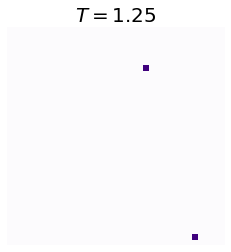

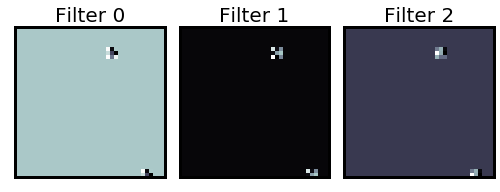

In [37]:
# Filters activations for a sample at critical region.

# Index for ordered samples.
idx = 2

plt.imshow(X_test[ordered_id[idx], : , :, 0], origin='lower', cmap='Purples')
plt.axis(False)
plt.title(r'$T= $' + str(Y_test[ordered_id[idx], 1]))
plt.show()

kernels_plot(filters_number, predict[ordered_id[idx], :, :, :])

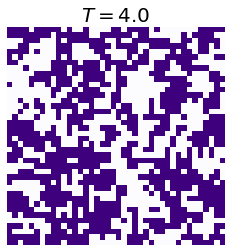

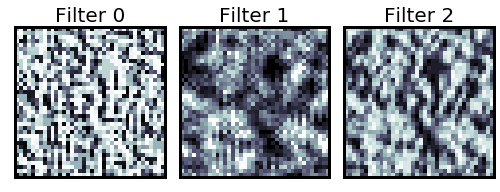

In [38]:
# Filters activations for a sample at critical region.

# Index for ordered samples.
idx = -1

plt.imshow(X_test[disordered_id[idx], : , :, 0], origin='lower', cmap='Purples')
plt.axis(False)
plt.title(r'$T= $' + str(Y_test[disordered_id[idx], 1]))
plt.show()

kernels_plot(filters_number, predict[disordered_id[idx], :, :, :])

## What CNN is seen

In [39]:
import keras.backend as K
import cv2
import seaborn as sns

In [40]:
def Grad_CAM(model_input, class_output, last_conv_layer_output, img, x, L):
    
    grads = K.gradients(class_output, last_conv_layer_output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model_input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    for i in range(conv_layer_output_value.shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    
    if np.max(heatmap) != 0.0:
        heatmap /= np.max(heatmap)
    
    heatmap = cv2.resize(heatmap, (L, L))
    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)
    
    aux = cv2.GaussianBlur(heatmap,(5,5),0) * 0.6 + img * 0.4
    
    plt.figure(figsize=[9,9])
    
    ax = plt.subplot(121)
    ax.imshow(aux, origin='lower', cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = plt.subplot(122)
    
    ax.imshow(img, origin='lower', cmap='Purples')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [41]:
layer_name = model.layers[0].name

class_output = model.output[:, 0]
last_conv_layer = model.get_layer(layer_name)

CNN prediction:  1.00 
True label:  1.00


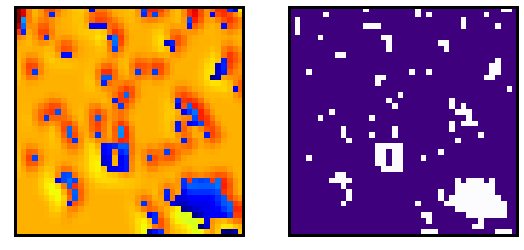

In [42]:
# Critical region.

idx = critical_id[-10]

x = np.reshape(X_test[idx], (1, L, L , 1))
img = x[0,:,:,0]

pred_c = model.predict(x)
print('CNN prediction: {0:5.2f} \nTrue label: {1:5.2f}'.format(pred_c[0][0], Y_test[idx, 0]))

Grad_CAM(model.input, class_output, last_conv_layer.output, img, x, L)

CNN prediction:  1.00 
True label:  1.00


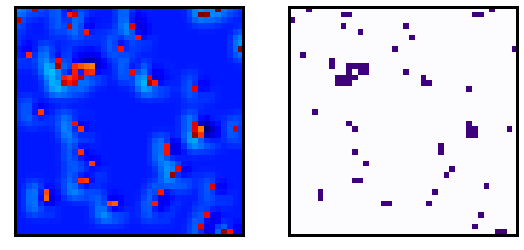

In [110]:
# Ordered region.

idx = ordered_id[27]

x = np.reshape(X_test[idx], (1, L, L , 1))
img = x[0,:,:,0]

pred_c = model.predict(x)
print('CNN prediction: {0:5.2f} \nTrue label: {1:5.2f}'.format(pred_c[0][0], Y_test[idx, 0]))

Grad_CAM(model.input, class_output, last_conv_layer.output, img, x, L)

CNN prediction:  0.00 
True label:  0.00


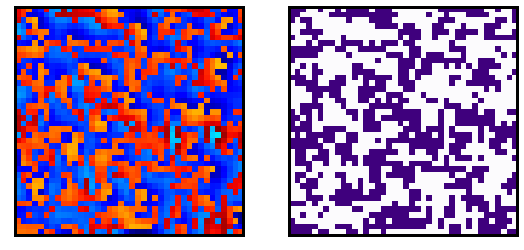

In [44]:
# Disordered region.

idx = disordered_id[10]

x = np.reshape(X_test[idx], (1, L, L , 1))
img = x[0,:,:,0]

pred_c = model.predict(x)
print('CNN prediction: {0:5.2f} \nTrue label: {1:5.2f}'.format(pred_c[0][0], Y_test[idx, 0]))

Grad_CAM(model.input, class_output, last_conv_layer.output, img, x, L)

In [111]:
quit()